# Contexto :

Em prol de melhorar a experiência e fidelizar seus clientes a UELLO coletou em sua base de dados os pedidos já entregues e solicitou ao time de ciências de dados para construir um modelo que os auxiliem em entender os atrasos e criar uma hipótese para evitá-los no futuro.

Dentro dessa solicitação a empresa também solicitou que fosse gerada uma coluna binária com as colunas que contém a data de prazo de entrega e a data real da entrega.

O gestor da área encontrou dois possíveis caminhos para gerar um modelo de ML que irá auxiliar na análise:

* Criar um previsor de atraso;
* Criar um classificador de pares ( origem e destino);

# Objetivo : 

Entender possíveis atrasos de pedidos.

# Features : 


*  **Id - Primary key**
*  **Price - Valor da entrega**
*  **Order_date - Data do pedido**
*  **Due_date - Data de entrega Esperada**
*  **Opt_date - Data em que o pedido sai para o destino**
*  **Delivery_date - Data de entrega**
*  **Cidade_origem_id - Cidade origem do pedido**
*  **Regiao_origem_id - Região origem do pedido**
*  **Cidade_destino_id - Cidade destino do pedido**
*  **Regiao_destino_id - Região destino do pedido**
*  **Peso - Peso do pacote**

# Importando bibliotecas :

In [918]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import plotly.express as px

import warnings
warnings.filterwarnings("ignore") 

import random

random.seed(1)

# Modelagem dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Métricas
from sklearn.metrics import r2_score, mean_squared_error , mean_absolute_error,median_absolute_error
from sklearn.metrics import f1_score,recall_score, precision_score
from sklearn.metrics import plot_roc_curve

# Exploração dos dados 

In [1215]:
df = pd.read_csv('ordens_case_dnc_.csv')

In [1309]:
df.head()

,delivery_date,id,price,order_date,due_date,opt_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,atraso,atraso_binario,faixa_preço,Dia_da_semana,Mês,Dia
0,2022-03-02 18:03:33,0,35.627382,2022-02-25 20:46:25,2022-03-02,2022-02-28 20:35:20,2,1,25,1,23.8,0,0,3,2,3,2
1,2022-02-24 15:52:40,1,7.470000,2022-02-23 20:34:59,2022-02-24,2022-02-24 09:56:23,2,1,16,4,536.0,0,0,1,3,2,24
2,2022-02-24 22:55:38,2,5.980000,2022-02-23 20:35:19,2022-02-24,2022-02-23 20:29:38,2,1,88,1,202.0,0,0,1,3,2,24
3,2022-02-17 14:23:12,3,5.980000,2022-02-10 14:34:37,2022-02-17,2022-02-17 07:47:49,2,1,21,1,441.0,0,0,1,3,2,17
4,2022-02-24 12:08:00,4,5.980000,2022-02-23 20:35:05,2022-02-24,2022-02-23 20:28:40,2,1,25,1,316.0,0,0,1,3,2,24


In [1147]:
df.shape

(1795, 11)

In [1148]:
df.dtypes

id                     int64
price                float64
order_date            object
due_date              object
opt_date              object
delivery_date         object
cidade_origem_id       int64
regiao_origem_id       int64
cidade_destino_id      int64
regiao_destino_id      int64
peso                 float64
dtype: object

# Tratamento de dados :

In [1216]:
# Transformando a variável 'Order_date' de object para datetime e removendo o fuso-horário
df['order_date'] = pd.to_datetime(df['order_date']).dt.tz_localize(None)

# Corrigindo o tipo de outras variáveis para uma melhor manipulação dos dados
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df['opt_date'] = pd.to_datetime(df['opt_date'])
df['due_date'] = pd.to_datetime(df['due_date'])

In [1156]:
df.dtypes

id                            int64
price                       float64
order_date           datetime64[ns]
due_date             datetime64[ns]
opt_date             datetime64[ns]
delivery_date        datetime64[ns]
cidade_origem_id              int64
regiao_origem_id              int64
cidade_destino_id             int64
regiao_destino_id             int64
peso                        float64
atraso                        int64
atraso_binario                int64
dtype: object

In [1151]:
# Analisando a quantidade de valores nulos e duplicados : 

print(f'Nulos : {df.isna().sum().sum()}')
print(f'Duplicados : {df.duplicated().sum()}')

Nulos : 0
Duplicados : 0


# EDA - Análise descritiva

In [1152]:
df.describe(percentiles=[0.25,0.5,0.75,0.8,0.90])

,id,price,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
count,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000
mean,897.000000,9.285142,3.482451,1.789972,25.604457,1.127577,622.271643
std,518.316184,13.171120,1.113963,0.676002,28.786272,0.576280,2619.830050
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,448.500000,5.980000,2.000000,1.000000,2.000000,1.000000,0.370000
50%,897.000000,6.550000,4.000000,2.000000,16.000000,1.000000,1.250000
75%,1345.500000,7.710000,4.000000,2.000000,37.000000,1.000000,342.500000
80%,1435.200000,8.200000,4.000000,2.000000,46.000000,1.000000,437.000000
90%,1614.600000,10.360000,5.000000,3.000000,73.000000,1.000000,979.800000
max,1794.000000,200.280000,5.000000,3.000000,127.000000,4.000000,43832.000000


In [563]:
def multplot(lista,dataframe):
    
    tipo = str(input('Qual tipo de gráfico você quer plotar? '))
    
    if tipo == 'hist':
        plt.figure(figsize=(18,9))
        for i in range(len(lista)):
            plt.subplot(2,len(lista)/2,i+1)
            sns.histplot(x=lista[i], bins=15,data=dataframe, kde= True)
            plt.title('Distribution plot - {}'.format(lista[i]))
            plt.tight_layout()
            
    elif tipo == 'boxplot':
        plt.figure(figsize=(18,9))
        for i in range(len(lista)):
            plt.subplot(2,len(lista)/2,i+1)
            sns.boxplot(y=df[lista[i]])
            plt.title('Boxplot plot - {}'.format(lista[i]))
            plt.tight_layout()

In [9]:
lista = ['price','regiao_origem_id','regiao_destino_id','cidade_origem_id','cidade_destino_id','peso']

Qual tipo de gráfico você quer plotar? hist


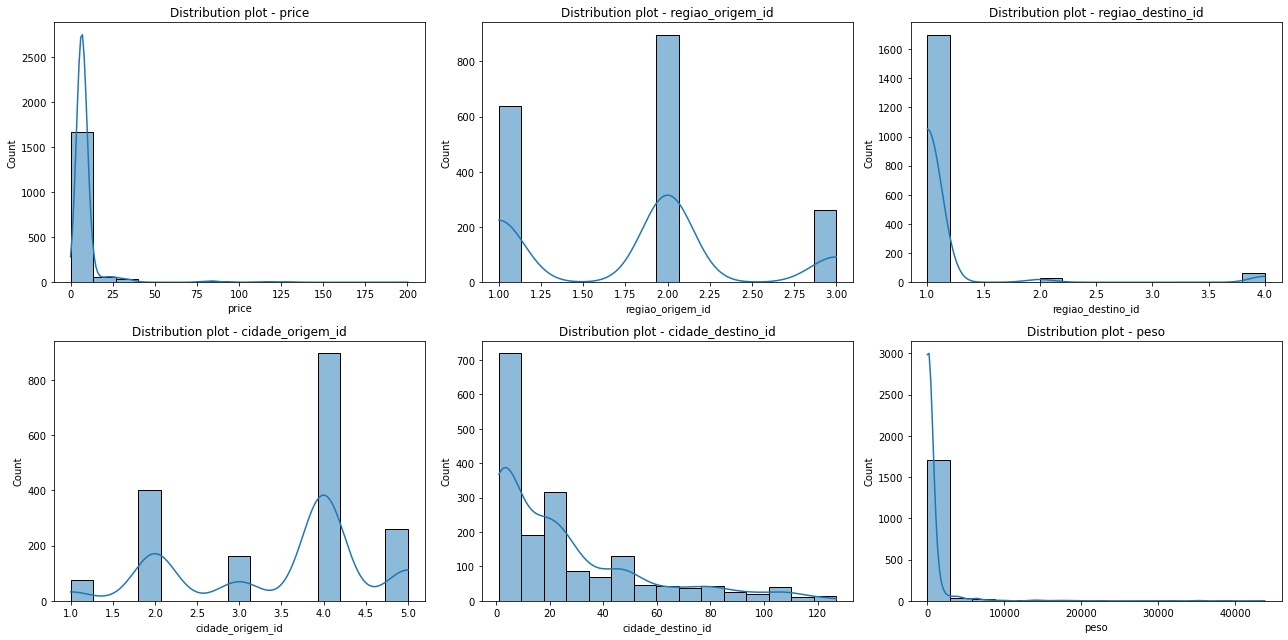

In [12]:
multplot(lista,df)

Qual tipo de gráfico você quer plotar? boxplot


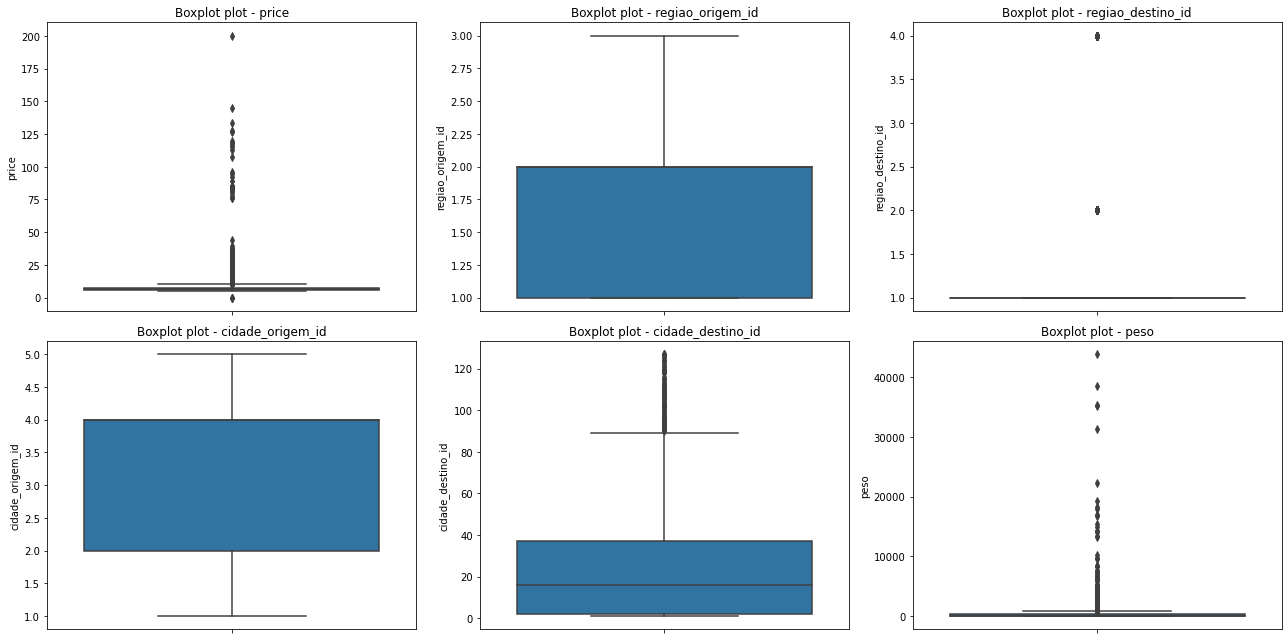

In [13]:
multplot(lista,df)

# Insights : 

* **Podemos perceber que existe uma concentração maior de pedidos na região 1, por isso que ao analisar o boxplot vemos que a região 2 e 4 são considerados outliers.**

* **Ao analisarmos a variável peso, percebemos uma quantidade muito grande de outliers quando os pesos são superiores a 500g, pois existe uma concetração maior de produtos mais leves do que mais pesados. E isso também causa outliers na variável preço.**

* **Os outliers nos preços também podem ser explicados pela rota que o produto passa, pois algumas regiões acabam sendo mais distantes.**

# Feature engieneering :


* Como nosso objetivo é analisar os atrasos, vamos criar a variável atraso, que não está presente no dataframe.

In [1217]:
df['atraso'] = (df.delivery_date - df.due_date).map(lambda x: x.components.days)

In [1218]:
df['atraso_binario'] = df['atraso'].apply(lambda x : 0 if x <=0 else 1)

In [1276]:
df.set_index('delivery_date',inplace=True)

In [1277]:
df['Dia_da_semana'] = df.index.dayofweek
df['Mês'] = df.index.month
df['Dia'] = df.index.day

In [1278]:
df.reset_index(inplace=True)

In [1279]:
df.corr()

,id,price,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,atraso,atraso_binario,Dia_da_semana,Mês,Dia
id,1.000000,0.092059,0.285662,0.416943,0.189273,0.000655,-0.042085,0.087633,0.148839,-0.053711,0.112108,-0.162053
price,0.092059,1.000000,-0.439943,-0.399517,-0.053381,0.204566,0.288970,0.131343,0.151862,-0.039358,0.062902,-0.117155
cidade_origem_id,0.285662,-0.439943,1.000000,0.929627,0.167997,-0.169738,-0.195497,-0.130547,-0.047118,-0.073151,0.018159,-0.003218
regiao_origem_id,0.416943,-0.399517,0.929627,1.000000,0.243763,-0.181581,-0.180763,-0.086134,-0.000054,-0.057639,0.075790,-0.090927
cidade_destino_id,0.189273,-0.053381,0.167997,0.243763,1.000000,-0.006029,0.013965,0.087933,0.162586,0.004530,0.131706,-0.234022
regiao_destino_id,0.000655,0.204566,-0.169738,-0.181581,-0.006029,1.000000,0.030210,0.067580,0.177282,-0.016842,0.027281,-0.043709
peso,-0.042085,0.288970,-0.195497,-0.180763,0.013965,0.030210,1.000000,0.016195,-0.010457,0.021987,-0.018189,0.022814
atraso,0.087633,0.131343,-0.130547,-0.086134,0.087933,0.067580,0.016195,1.000000,0.633730,-0.170082,0.482928,-0.302717
atraso_binario,0.148839,0.151862,-0.047118,-0.000054,0.162586,0.177282,-0.010457,0.633730,1.000000,0.109346,0.492751,-0.387957
Dia_da_semana,-0.053711,-0.039358,-0.073151,-0.057639,0.004530,-0.016842,0.021987,-0.170082,0.109346,1.000000,0.041771,-0.043612


# Visualização das novas variáveis

<AxesSubplot:xlabel='Mês', ylabel='atraso_binario'>

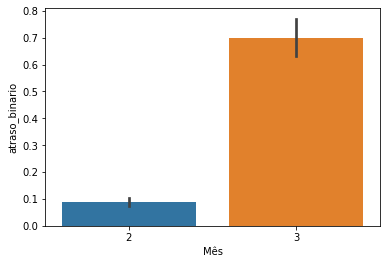

In [1307]:
sns.barplot(x=df['Mês'],y=df['atraso_binario'])

Podemos perceber que o mês 3 possui uma quantidade maior de atrasos.

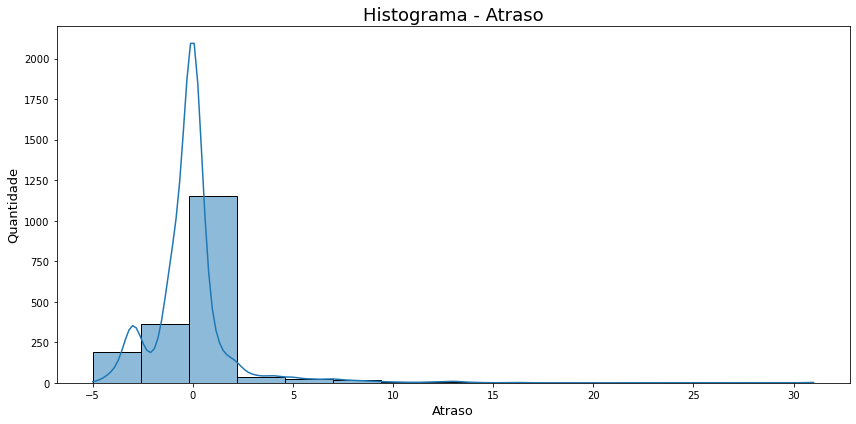

In [17]:
plt.figure(figsize=(12,6))
sns.histplot(x=df['atraso'],bins=15, kde= True)
plt.title('Histograma - Atraso',fontsize=18)
plt.xlabel('Atraso',fontsize=13)
plt.ylabel('Quantidade',fontsize=13)
plt.tight_layout()

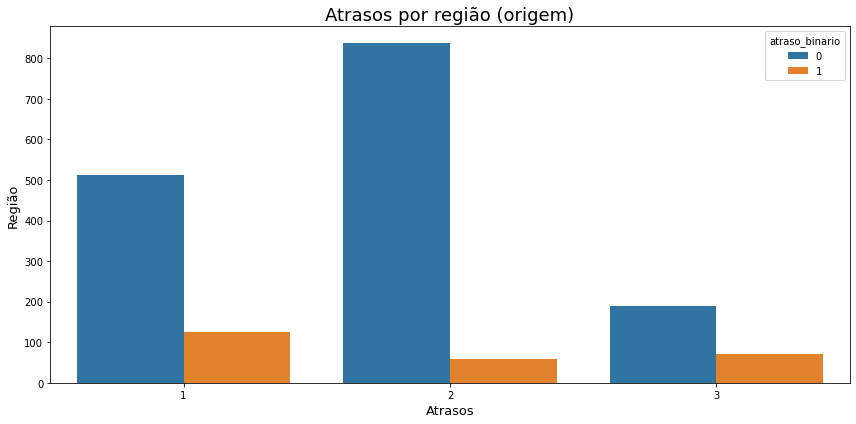

In [18]:
plt.figure(figsize=(12,6))
plt.title('Atrasos por região (origem)',fontsize=18)
sns.countplot(x='regiao_origem_id',hue='atraso_binario',data=df)
plt.xlabel('Atrasos',fontsize=13)
plt.ylabel('Região',fontsize=13)
plt.tight_layout()

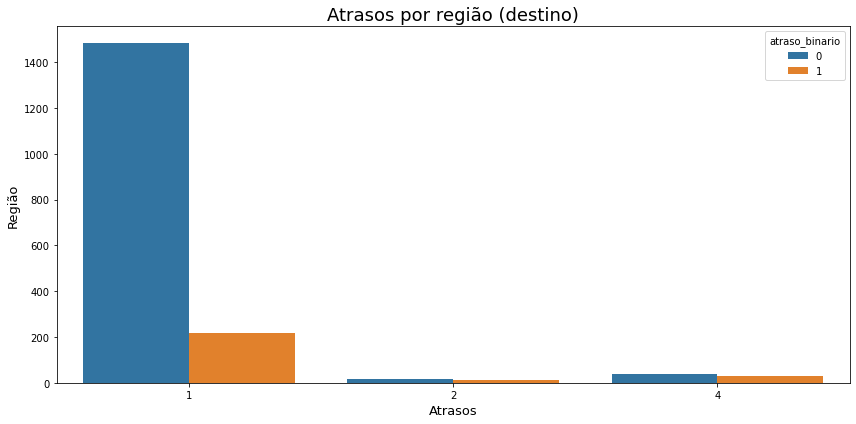

In [19]:
plt.figure(figsize=(12,6))
plt.title('Atrasos por região (destino)',fontsize=18)
sns.countplot(x='regiao_destino_id',hue='atraso_binario',data=df)
plt.xlabel('Atrasos',fontsize=13)
plt.ylabel('Região',fontsize=13)
plt.tight_layout()

<AxesSubplot:xlabel='regiao_origem_id', ylabel='atraso'>

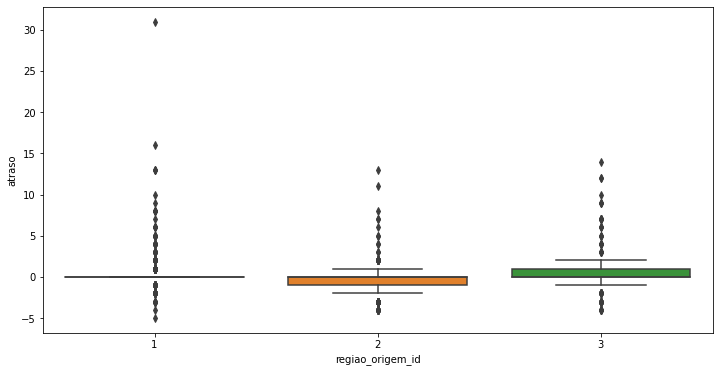

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['regiao_origem_id'],y=df['atraso'])

<AxesSubplot:xlabel='regiao_destino_id', ylabel='atraso'>

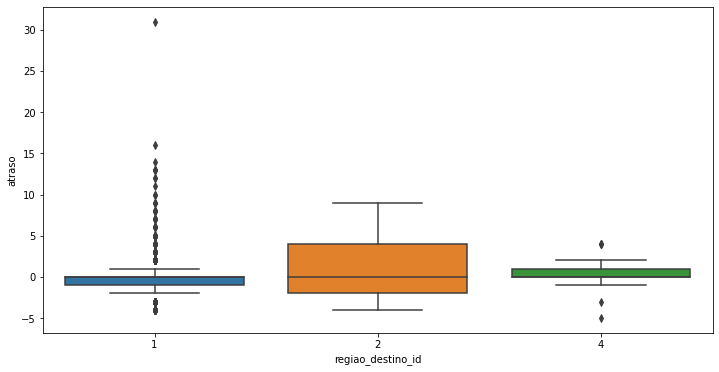

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['regiao_destino_id'],y=df['atraso'])

In [566]:
tabela1 = pd.DataFrame(df.groupby(['regiao_origem_id','regiao_destino_id'])['atraso_binario'].value_counts())

In [567]:
tabela1 = tabela1.rename(columns={'atraso_binario':'Qtd_de_Atrasos'})

In [568]:
tabela1 = tabela1.reset_index()

In [1219]:
tabela1

,regiao_origem_id,regiao_destino_id,atraso_binario,Qtd_de_Atrasos
0,1,1,0,470
1,1,1,1,94
2,1,2,0,6
3,1,2,1,4
4,1,4,0,36
5,1,4,1,28
6,2,1,0,837
7,2,1,1,59
8,3,1,0,175
9,3,1,1,63


In [1220]:
grafico1 = tabela1.loc[tabela1['regiao_origem_id'] ==1]
grafico2 = tabela1.loc[tabela1['regiao_origem_id'] ==2]
grafico3 = tabela1.loc[tabela1['regiao_origem_id'] ==3]

lista = [grafico1,grafico2,grafico3]

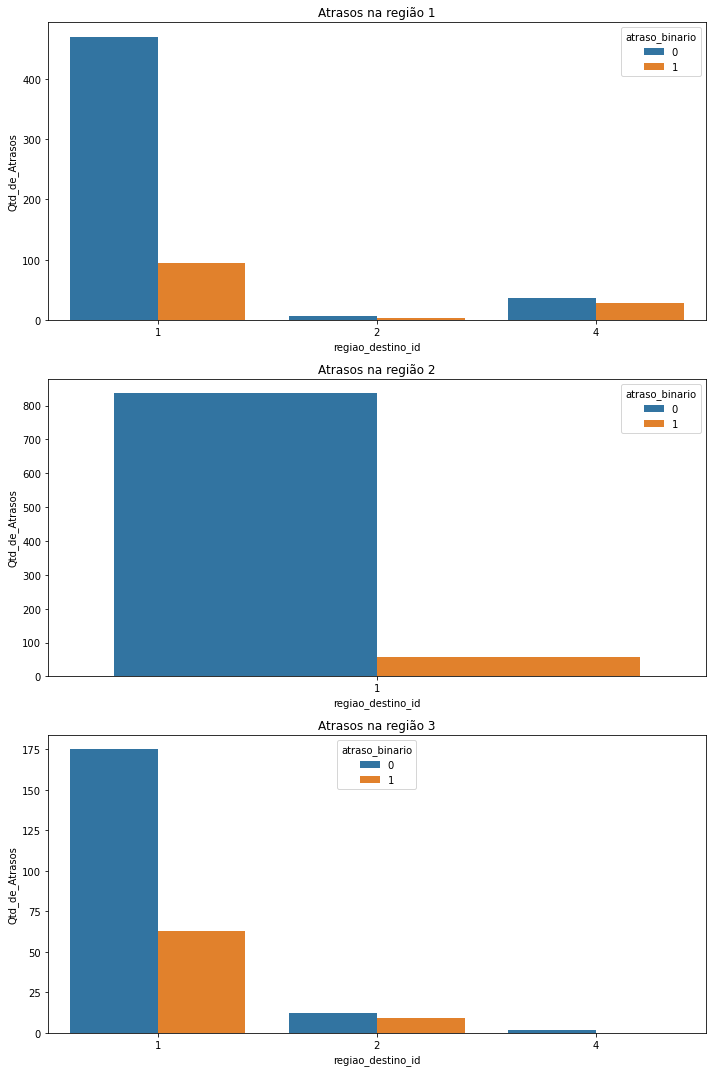

In [142]:
plt.figure(figsize=(10,15))
for i in range(len(lista)):
    plt.subplot(3,1,i+1)
    sns.barplot(x='regiao_destino_id',y='Qtd_de_Atrasos',hue='atraso_binario',data=lista[i])
    plt.title(f'Atrasos na região {i+1}')
    plt.tight_layout()

<AxesSubplot:xlabel='regiao_destino_id', ylabel='Qtd_de_Atrasos'>

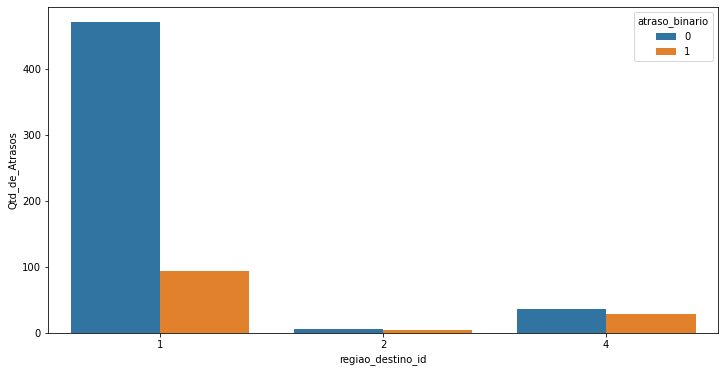

In [129]:
plt.figure(figsize=(12,6))
sns.barplot(x='regiao_destino_id',y='Qtd_de_Atrasos',hue='atraso_binario',data=grafico1)

# Insights :

* **Podemos perceber uma grande quantidade de atrasos e a maioria é de 1 dia.**
* **Existem uma quantidade relevante de situações em que o produto chegou mais cedo do que esperado.**
* **A região origem que mais possui casos de atrasos é a região 3**
* **E a região destino que mais possui casos de atrasos é a região 2**
* **Podemos perceber que a região 1 é a que possui o maior volume de entregas, pois além de enviar pra todas ela envia pra ela mesma**
* **A região 3 só realiza envios e a região 4 só recebe encomendas.**

# Correlação :

In [1221]:
df.corr()

,id,price,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,atraso,atraso_binario
id,1.000000,0.094671,0.285662,0.416943,0.189273,0.000655,-0.042085,0.087633,0.148839
price,0.094671,1.000000,-0.297614,-0.267021,-0.030185,0.173071,0.144563,0.103665,0.141224
cidade_origem_id,0.285662,-0.297614,1.000000,0.929627,0.167997,-0.169738,-0.195497,-0.130547,-0.047118
regiao_origem_id,0.416943,-0.267021,0.929627,1.000000,0.243763,-0.181581,-0.180763,-0.086134,-0.000054
cidade_destino_id,0.189273,-0.030185,0.167997,0.243763,1.000000,-0.006029,0.013965,0.087933,0.162586
regiao_destino_id,0.000655,0.173071,-0.169738,-0.181581,-0.006029,1.000000,0.030210,0.067580,0.177282
peso,-0.042085,0.144563,-0.195497,-0.180763,0.013965,0.030210,1.000000,0.016195,-0.010457
atraso,0.087633,0.103665,-0.130547,-0.086134,0.087933,0.067580,0.016195,1.000000,0.633730
atraso_binario,0.148839,0.141224,-0.047118,-0.000054,0.162586,0.177282,-0.010457,0.633730,1.000000


# Tratamento de outliers : 

In [1361]:
media = df['price'].mean()
desviop = df['price'].std()
l_superior = media + (desviop * 2)
l_inferior = media  - (desviop * 2)

In [1362]:
print(f'limite superior = {l_superior}')
print(f'limite inferior = {l_inferior}')

limite superior = 19.554494765502046
limite inferior = -3.1252932235241495


In [1363]:
df.loc[df['price'] > l_superior, ['price']] = l_superior

<AxesSubplot:xlabel='atraso'>

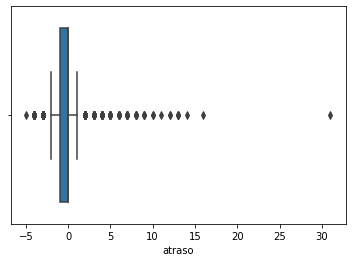

In [1364]:
sns.boxplot(df['atraso'])

In [1060]:
df.describe(percentiles=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99))

,id,price,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,atraso
count,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000
mean,897.000000,8.214601,3.482451,1.789972,25.604457,1.127577,622.271643,-0.113092
std,518.316184,5.669947,1.113963,0.676002,28.786272,0.576280,2619.830050,2.073892
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-5.000000
10%,179.400000,5.490000,2.000000,1.000000,2.000000,1.000000,0.200000,-3.000000
20%,358.800000,5.980000,2.000000,1.000000,2.000000,1.000000,0.300000,-1.000000
30%,538.200000,5.980000,3.000000,1.000000,2.000000,1.000000,0.430000,-1.000000
40%,717.600000,5.980000,4.000000,2.000000,9.000000,1.000000,0.740000,0.000000
50%,897.000000,6.550000,4.000000,2.000000,16.000000,1.000000,1.250000,0.000000
60%,1076.400000,6.986000,4.000000,2.000000,24.000000,1.000000,20.864000,0.000000


Podemos ver uma quantidade significante de outliers discrepantes na nossa variável target,80% dos valores estão em zero, entre 90% e 99% existe um aumento de sete,e de 99% até o máximo existe uma discrepância ainda maior.

Para isso, vamos remover esses dados muito discrepantes e que aparecem com uma frequência bem inferior, pois eles podem enviesar o modelo. 

In [1365]:
indices = df.loc[df['atraso']>3].index

In [1366]:
df.drop(indices,axis=0,inplace=True)

In [1367]:
indices = df.loc[df['atraso']<-3].index

In [1166]:
df.drop(indices,axis=0,inplace=True)

In [1368]:
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)

# Feature engineering

In [1371]:
df['faixa_preço'] = 0

In [1372]:
for i in df.index:
    if (df['price'].iloc[i]>=0) & (df['price'].iloc[i]<=10):
        df['faixa_preço'].iloc[i] = '1'

    elif (df['price'].iloc[i]>10) & (df['price'].iloc[i]<=20):
        df['faixa_preço'].iloc[i] = '2'

    elif (df['price'].iloc[i]>20) & (df['price'].iloc[i]<=l_superior):
        df['faixa_preço'].iloc[i] = '3'

In [1374]:
df['faixa_preço'].unique()

array(['2', '1'], dtype=object)

# One Hot Encoding

Vamos utilizar técnicas de one hot encoding para transformar nossos dados categoricos em novas colunas para nosso dataframe.

Mas antes precisamos corrigir as colunas que são categoricas, mas por se tratarem de números são reconhecidas como númericas.

In [1323]:
lista = ['regiao_origem_id','regiao_destino_id','cidade_origem_id','cidade_destino_id']

In [1324]:
def mudança_tipo(lista,dataframe):
    
    for i in lista:
        dataframe[i] =  dataframe[i].astype(str)
        


In [1379]:
df_modelo=df.drop(columns=['id','price','due_date','opt_date','delivery_date','order_date','peso','Dia_da_semana','Dia'])

In [1380]:
mudança_tipo(lista,df_modelo)

In [1381]:
df_modelo = pd.get_dummies(df_modelo,drop_first=True)

In [1382]:
df_modelo

,atraso,atraso_binario,Mês,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,regiao_origem_id_2,regiao_origem_id_3,cidade_destino_id_10,...,cidade_destino_id_92,cidade_destino_id_94,cidade_destino_id_95,cidade_destino_id_96,cidade_destino_id_97,cidade_destino_id_98,cidade_destino_id_99,regiao_destino_id_2,regiao_destino_id_4,faixa_preço_2
0,0,0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1718,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1719,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1720,0,0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modelagem : 

* Para encontrar o melhor modelo, irei criar uma lista com diversos e ver qual possui a melhor métrica escolhida.

* Nesta situação, optei por usar métricas que envolvem o erro, pois o resultado delas é na mesma unidade da variável target, sendo assim mais fácil de indentificarmos a quantidade de dias de atraso que nosso modelo irá prever.

In [1383]:
X = df_modelo.drop(columns=['atraso','atraso_binario'])
y =df_modelo['atraso']

In [1384]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=1)

In [1385]:
models = {
    'LinearReg': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'SVM_RBF':SVR(kernel='rbf'),
    'SVM_POLY':SVR(kernel='poly'),
    'SVM_LINEAR':SVR(kernel='linear',max_iter=10**4),
    'SVM_SIG':SVR(kernel='sigmoid'),
    'RandomForestRegressor':RandomForestRegressor(),
    'XGBRegressor':XGBRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor(),
    'ExtraTreesRegressor':ExtraTreesRegressor(),
    'MLPRegressor' : MLPRegressor()
}

comparativo = pd.DataFrame(columns=['y_test'])
comparativo['y_test'] = y_test

for model in models.values():
    
    model.fit(X_train, y_train)
    
nome=[]
RMSE = []
r2 = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    RMSE.append((mean_squared_error(y_test,y_pred,squared=False)))
    r2.append((r2_score(y_test,y_pred)))
    nome.append(name)
    print('-------------------------')
    print(f' RMSE : {name} = {(mean_squared_error(y_test,y_pred,squared=False)):.2f}')
    print('-------------------------') 
    
    comparativo[name] = y_pred.astype('int64')
    

-------------------------
 RMSE : LinearReg = 5601296312414.74
-------------------------
-------------------------
 RMSE : DecisionTreeRegressor = 1.10
-------------------------
-------------------------
 RMSE : SVM_RBF = 1.03
-------------------------
-------------------------
 RMSE : SVM_POLY = 1.03
-------------------------
-------------------------
 RMSE : SVM_LINEAR = 1.02
-------------------------
-------------------------
 RMSE : SVM_SIG = 1.28
-------------------------
-------------------------
 RMSE : RandomForestRegressor = 1.07
-------------------------
-------------------------
 RMSE : XGBRegressor = 1.05
-------------------------
-------------------------
 RMSE : GradientBoostingRegressor = 1.03
-------------------------
-------------------------
 RMSE : ExtraTreesRegressor = 1.10
-------------------------
-------------------------
 RMSE : MLPRegressor = 1.06
-------------------------


In [1386]:
tabela = pd.DataFrame(columns={'RMSE'},index=(nome))
tabela['RMSE'] = RMSE

In [1387]:
tabela

,RMSE
LinearReg,5.601296e+12
DecisionTreeRegressor,1.102018e+00
SVM_RBF,1.026301e+00
SVM_POLY,1.034361e+00
SVM_LINEAR,1.024145e+00
SVM_SIG,1.279480e+00
RandomForestRegressor,1.068958e+00
XGBRegressor,1.054172e+00
GradientBoostingRegressor,1.026811e+00
ExtraTreesRegressor,1.102895e+00


# Modelo selecionado :

MLPRegressor - 

RMSE = 1.07

Isso quer dizer que nosso modelo está com um erro de + ou - 1 dia

In [1417]:
teste = X.copy()

In [1418]:
model = MLPRegressor()
model.fit(X_train,y_train)

MLPRegressor()

In [1419]:
yPrevs = model.predict(teste)

In [1420]:
teste['Atraso_validacao'] = yPrevs
teste['Atraso'] = y

In [1421]:
teste.loc[teste['Atraso']==3]

,Mês,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,regiao_origem_id_2,regiao_origem_id_3,cidade_destino_id_10,cidade_destino_id_100,cidade_destino_id_101,...,cidade_destino_id_95,cidade_destino_id_96,cidade_destino_id_97,cidade_destino_id_98,cidade_destino_id_99,regiao_destino_id_2,regiao_destino_id_4,faixa_preço_2,Atraso_validacao,Atraso
27,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2.980373,3
154,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.356523,3
272,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.645106,3
646,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.094808,3
852,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.015116,3
1223,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,2.126540,3
1229,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.188155,3
1249,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.936797,3
1255,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.775015,3
1313,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.433173,3


* Como podemos perceber, o modelo está bem acertivo